In [155]:
import numpy as np
from skimage.transform import resize
from skimage import color
import matplotlib.pyplot as plt
import IPython

%load_ext autoreload
%autoreload 2
%matplotlib inline

def scale_data(vol, seg, size=180):
    length = vol.shape[0]
    vol = resize(vol, (length, size, size))
    seg = resize(seg, (length, size, size), order=0, preserve_range=True, anti_aliasing=False)

    return (vol, seg)
    
def label_data(vol, seg):
    length = vol.shape[0]
    size = vol.shape[1]
    # reshape for labeling
    seg = np.reshape(seg, (size, length*size) )
    vol = np.reshape(vol, (size, length*size) )
    # label
    labeled = color.label2rgb(seg, vol, alpha=0.1, bg_label=0)
    # shape back
    labeled = np.reshape(labeled, (length, size, size, 3) )

    return labeled

def vis_volume(volume, fig_size=6.5):
    length = volume.shape[0]
    
    # set up
    fig = plt.figure()
    fig.set_size_inches(fig_size, fig_size)
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)

    # display
    for i in range(length):
        axes.imshow(volume[i], cmap='gray', interpolation='none', filternorm=False, resample=False)
        fig.canvas.draw()
        hfig.update(fig)
        if i != length-1:
            plt.cla()
    # clean up
    IPython.display.clear_output()

def view_patch(patch,i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(3,4)
    fig.set_size_inches(16, 10)
    axarr[0,0].imshow(patch.image[0][i], cmap='gray')
    axarr[0,1].imshow(patch.label[0][i], cmap='prism')
    axarr[0,2].imshow(label_data(patch.image[0],patch.label[0])[i])
    axarr[1,0].imshow(patch.affinity[0][i], cmap='gray')
    axarr[1,1].imshow(patch.affinity[1][i], cmap='gray')
    axarr[1,2].imshow(patch.affinity[2][i], cmap='gray')
    axarr[2,0].imshow(patch.get_lsd_channel(0)[i,:,:,0])
    axarr[2,1].imshow(patch.get_lsd_channel(1)[i,:,:,0])
    axarr[2,2].imshow(patch.get_lsd_channel(2)[i,:,:,0])
    axarr[2,3].imshow(patch.get_lsd_channel(3)[i], cmap='gray')
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
from neutorch.dataset.affinity import Dataset
from neutorch.dataset.ground_truth_volume import *

dataset = Dataset('../../data', patch_size=(26,256,256), length=100)

loading file sample_A...


In [178]:
patch = dataset.random_training_patch
affinity = patch.affinity
label = patch.label
image = patch.image

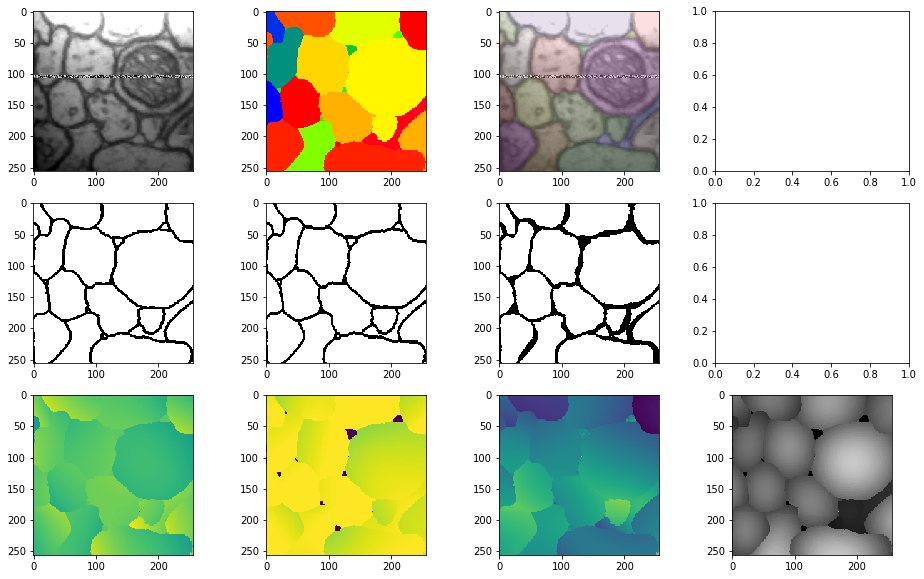

In [179]:
view_patch(patch)

[0. 1.]
Re-using already compiled waterz version


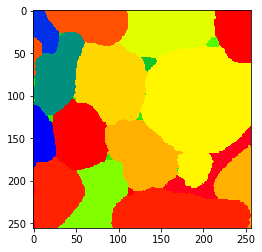

Preparing segmentation volume...
(26, 256, 256) {'V_Rand_split': 0.6371490434540554, 'V_Rand_merge': 0.07501453643368702, 'V_Info_split': 0.7995528477826088, 'V_Info_merge': 4.051641719250352}
5


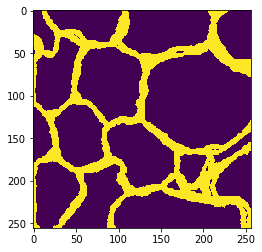

In [181]:
from waterz import agglomerate
import numpy as np


# affs is a [3, z, y, x] numpy array of float32
print(np.unique(affinity))
affs = np.flip(affinity, axis=0)
affs = np.ascontiguousarray(affs, dtype=np.float32) 
inv_aff = np.zeros(affs.shape)
inv_aff[affs == 0] = 1
inv_aff[affs == 1] = 0
inv_aff = np.ascontiguousarray(inv_aff, dtype=np.float32) 

ground_truth = np.ascontiguousarray(label[0], dtype=np.uint32) 
thresholds = [2]

seg_generator = agglomerate(inv_aff, thresholds, gt=ground_truth,
       aff_threshold_low=0.001,
        aff_threshold_high=0.999,
        return_merge_history=True,
        return_region_graph=False)

i=0
plt.imshow(label[0][i], cmap='prism')
plt.show()
for seg, metrics, merge_history in seg_generator:
        print(seg.shape, metrics)
        print(len(np.unique(seg)))
        plt.imshow(seg[i])
        plt.show()
